In [1]:
#!/usr/bin/env python
"""
Script to calculate Mutual Information between two discrete random variables

Roberto Maestre - rmaestre@gmail.com
Bojan Mihaljevic - boki.mihaljevic@gmail.com
"""
from __future__ import division
from numpy import array, shape, where, in1d
import math
import time
import nose

class InformationTheoryTool:
    
    def __init__(self, data):
        """
        """
        # Check if all rows have the same length
        assert (len(data.shape) == 2)
        # Save data
        self.data = data
        self.n_rows = data.shape[0]
        self.n_cols = data.shape[1]
        
        
    def single_entropy(self, x_index, log_base, debug=False):
        """
        Calculate the entropy of a random variable
        """
        # Check if index are into the bounds
        assert (x_index >= 0 and x_index <= self.n_rows)
        # Variable to return entropy
        summation = 0.0
        # Get unique values of random variables
        values_x = set(self.data[x_index])
        # Print debug info
        if debug:
            print('Entropy of')
            print(self.data[x_index])
        # For each random value
        for value_x in values_x:
            px = shape(where(self.data[x_index] == value_x))[1] / self.n_cols
            if px > 0.0:
                summation += px * math.log(px, log_base)
            if debug:
                print(f'({value_x}) px:{px}')
        if summation == 0.0:
            return summation
        else:
            return -summation
        
        
    def entropy(self, x_index, y_index, log_base, debug=False):
        """
        Calculate the entropy between two random variables
        """
        assert (x_index >= 0 and x_index <= self.n_rows)
        assert (y_index >= 0 and y_index <= self.n_rows)
        # Variable to return entropy
        summation = 0.0
        # Get unique values of random variables
        values_x = set(self.data[x_index])
        values_y = set(self.data[y_index])
        # Print debug info
        if debug:
            print('Entropy between')
            print(self.data[x_index])
            print(self.data[y_index])
        # For each random value pair
        for value_x in values_x:
            for value_y in values_y:
                pxy = len(where(in1d(where(self.data[x_index] == value_x)[0], 
                                     where(self.data[y_index] == value_y)[0]) == True)[0]) / self.n_cols
                if pxy > 0.0:
                    summation += pxy * math.log(pxy, log_base)
                if debug:
                    print(f'({value_x},{value_y}) pxy:{pxy}')
        if summation == 0.0:
            return summation
        else:
            return -summation
        
        
    def mutual_information(self, x_index, y_index, log_base, debug=False):
        """
        Calculate and return Mutual Information between two random variables
        """
        # Check if index are into the bounds
        assert (x_index >= 0 and x_index <= self.n_rows)
        assert (y_index >= 0 and y_index <= self.n_rows)
        # Variable to return MI
        summation = 0.0
        # Get unique values of random variables
        values_x = set(self.data[x_index])
        values_y = set(self.data[y_index])
        # Print debug info
        if debug:
            print('MI between')
            print(self.data[x_index])
            print(self.data[y_index])
        # For each random value pair
        for value_x in values_x:
            for value_y in values_y:
                px = shape(where(self.data[x_index] == value_x))[1] / self.n_cols
                py = shape(where(self.data[y_index] == value_y))[1] / self.n_cols
                pxy = len(where(in1d(where(self.data[x_index] == value_x)[0], 
                                     where(self.data[y_index] == value_y)[0]) == True)[0]) / self.n_cols
                if pxy > 0.0:
                    summation += pxy * math.log((pxy / (px * py)), log_base)
                if debug:
                    print(f'({value_x},{value_y}) px:{px} py:{py} pxy:{pxy}')
        return summation


In [1]:
import pandas as pd
import os
from scipy.interpolate import PchipInterpolator
import numpy as np
import copy
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt

In [237]:
#dataframe datos de compositores 

datos_composers = {}
carpeta = r'Sequences\labels'
archivos_en_carpeta = os.listdir(carpeta)
index0 = 0
indice = 0

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa, header = None)
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    datos_composers[composer] = {} #genero bibio para composer
    datos_composers[composer]['Birth_year'] = archivo.split('-')[0] #año de nacimiento
    index1 = serie.iloc[0, 0].split('\t')[0] #el # del primer serie del composer
    index2 = int(serie.iloc[len(serie)-3, 0].split('\t')[0]) - index0 # # Piezas
    index0 = index2 + index0 # numero total de piezas anteriores
    datos_composers[composer]['# Piezas'] = index2 # Piezas
    datos_composers[composer]['Indice'] = indice
    indice += 1

composers = {}
M = 0
carpeta = r'Sequences\Series'
archivos_en_carpeta = os.listdir(carpeta)

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa)
    # escoge una serie
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    composers[composer] = {}

    for pieza in range( datos_composers[composer]['# Piezas'] ):
        N = serie.iloc[0, 0].split('\t')[1] # # de elementos por pieza
        M = int(N) + M
        index_n1 = 0 
        index_n2 = int(N)+2 
        serie_n = serie[index_n1 + 2:index_n2].reset_index(drop=True) # resetear index
        serie = serie[index_n2 +1:] # recortar serie Original
        serie_n.index += 1 # que index empiece desde 1
        num_serie_T = serie.columns[0]  # numero de serie de todo el dataset
        num_serie = pieza + 1
        composers[composer]['Serie_'+str(num_serie)] = serie_n.squeeze().to_numpy().astype(float) # agregamos pieza al dicc composer con key como # serie

###
###

composers_depurado = copy.deepcopy(composers)
datos_composers_depurado = copy.deepcopy(datos_composers)

for i,composer in enumerate(composers.keys()):
    d = 0
    for pieza in composers[composer].keys():
        if len(composers[composer][pieza])//2 < 400:
            del composers_depurado[composer][pieza]
            d = d + 1
    datos_composers_depurado[composer]['# Piezas'] = datos_composers[composer]['# Piezas'] - d


# 40 promedio de numero de piezas por compositor
composers_depurado_v2 = copy.deepcopy(composers_depurado)
composers_depurado_v2_keychange = copy.deepcopy(composers_depurado_v2)
datos_composers_depurado_v2 = copy.deepcopy(datos_composers_depurado)

for composer in composers.keys():
    if datos_composers_depurado[composer]['# Piezas'] < 30:
        del composers_depurado_v2[composer]
        del datos_composers_depurado_v2[composer]
    
for i,composer in enumerate(composers_depurado_v2.keys()):
    datos_composers_depurado_v2[composer]['Indice'] = i 

for composer in composers_depurado_v2.keys():
    for i,serie in enumerate(composers_depurado_v2[composer].keys()):
        composers_depurado_v2_keychange[composer]['Serie_' + str(i+1)] = composers_depurado_v2_keychange[composer].pop(serie)

print(" # de compositores restantes: ", len(composers_depurado_v2))

 # de compositores restantes:  19


In [264]:
def generar_uniforme_centrada(n, varianza):
    # Calcular el límite superior e inferior de la distribución uniforme
    limite = np.sqrt(varianza)
    # Generar n números aleatorios con distribución uniforme entre -limite y limite
    return np.random.uniform(-limite, limite, n)

In [98]:
def log2(x):
    x[x == 0] = 1  # Evitar problemas con log(0)
    return np.log2(x)

# Función para calcular la información mutua
def calcular_informacion_mutua(x, y, bins=30):
    # Discretizar ambas variables en bins
    hist_conj, edges_x, edges_y = np.histogram2d(x, y, bins=bins)
    prob_conj = hist_conj / np.sum(hist_conj)  # Probabilidad conjunta

    # Probabilidades marginales
    prob_x = np.sum(prob_conj, axis=1)  # Marginal en X
    prob_y = np.sum(prob_conj, axis=0)  # Marginal en Y

    # Entropías
    H_x = -np.sum(prob_x * log2(prob_x))
    H_y = -np.sum(prob_y * log2(prob_y))
    H_conj = -np.sum(prob_conj * log2(prob_conj))

    # Información mutua
    I_xy = H_x + H_y - H_conj
    return I_xy, H_x, H_y, H_conj

In [363]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression

def mutual_information_knn(X, Y, k=5, base=2):
    """
    Calcula la Información Mutua entre X e Y usando KNN.

    Parámetros:
    - X, Y: Arrays 1D con los datos.
    - k: Número de vecinos más cercanos.
    - base: Base del logaritmo (2 para bits, np.e para nats).

    Retorna:
    - I(X; Y): Información Mutua estimada.
    """
    X = X.reshape(-1, 1)  # Convertir X a 2D para sklearn
    Y = Y.ravel()  # Asegurar que Y es 1D

    mi = mutual_info_regression(X, Y, discrete_features=False, n_neighbors=k)
    
    return mi[0] / np.log(base)  # Ajustar la base del logaritmo

# Simulación de datos continuos
np.random.seed(42)
X = np.random.randn(2677)  # X normal
Y = 0.5 * X + 0.1 * np.random.randn(2677)  # Y correlacionado con X
# print(np.shape(X.reshape(-1, 1)), np.shape(Y.ravel()))
# Calcular Información Mutua con KNN
I_XY = mutual_information_knn(X, Y, k=5, base=2)
print(f"Información Mutua I(X; Y): {I_XY} bits")


Información Mutua I(X; Y): 2.3818491374714355 bits


In [297]:
data2 = np.array([
    np.array(np.linspace(-200,200,2677)),  # Variable X
    np.sin(np.linspace(-200,200,2677))*2   # Variable Y
])
mutual_information(data2[0,:],data2[1,:])

(0.34353726030210735, 3.401186170845807, 3.228569082088971)

In [429]:
import random
Js = np.load('J_composers_global.npy')
xi = np.load('xi_index_global.npy')
data = []
# data2 = np.array([
    # np.random.randn(2677),  # Variable X
    # np.random.randn(2677)   # Variable Y
data2 = np.array([
    np.array(np.linspace(-200,200,2677)),  # Variable X
    np.sin(np.linspace(-200,200,2677))*2   # Variable Y
])
for pts_interp in [2]:
    print(pts_interp)
    list1 = []
    for _ in range(100):
        # pts_interp = 2
        Js = np.array([])
        for composer in composers_depurado_v2.keys():
                array = 1-np.load('J_lineal_sincorte_depurado/interp_'+str(pts_interp)+'/'+ str(datos_composers[composer]['Birth_year']) + '_J_interp_' + str(composer) + '_lineal.npy')
                Js = np.concatenate((Js,array))
        # data2 = np.array([
        #     xi,  # Variable X
        #     Js   # Variable Y
        # ])

        null = []
        # print(calcular_informacion_mutua(data2[0,:],data2[1,:]))
        # print(mutual_information(data2[0,:],data2[1,:]))
        for _ in range(1000):
            # for i in range(10):
                # random.shuffle(Js_random)
            shuffled_array = random.sample(list(data2[0,:]), len(data2[0,:])) 
            Mi = mutual_information_knn(np.array(shuffled_array),np.array(data2[1,:]))
            null.append(Mi)
        print(len(list1))

        MI_index = (mutual_information_knn(np.array(data2[0,:]),np.array(data2[1,:]))- np.mean(null))/np.std(null)
        list1.append(MI_index)
    data.append(list1)

# calcular_informacion_mutua(data2[0,:],data2[1,:])

2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [407]:
data_knn = [[-0.678031449888841,
  -0.6805773321862919,
  -0.686787065007776,
  -0.6615528852617621,
  -0.648913549819569,
  -0.71353783727023,
  -0.6766335042028114,
  -0.6954536508675518,
  -0.6973649142417759,
  -0.6362288771075082,
  -0.6824097612781336,
  -0.6723929792134121,
  -0.6775236676958378,
  -0.706265461355683,
  -0.7101962051717037,
  -0.6638713429484925,
  -0.6707046907669885,
  -0.6942343032741459,
  -0.6509362393058414,
  -0.6710198419896772,
  -0.6945251368863388,
  -0.6878777537168538,
  -0.6606331587693429,
  -0.6502456272372739,
  -0.6978520582889797,
  -0.6521978713415215,
  -0.6919806960188255,
  -0.7182307052003598,
  -0.6991467039182071,
  -0.6709015524403178,
  -0.651761060548956,
  -0.6756946866622007,
  -0.6883911183827326,
  -0.6717205578275401,
  -0.7107225804260204,
  -0.6843999729979316,
  -0.697106484001476,
  -0.6661727388199543,
  -0.6691715104343352,
  -0.6582111775609816,
  -0.6765656264932753,
  -0.6585885872652162,
  -0.7107237218323129,
  -0.6620289372404885,
  -0.6438092654888091,
  -0.6576901528587284,
  -0.6635988365180894,
  -0.6842750941875007,
  -0.6598241948659648,
  -0.6859550925941508,
  -0.6665845536651663,
  -0.6499851075800601,
  -0.6672528101965561,
  -0.6496379644530391,
  -0.6585172903830845,
  -0.7204013261022861,
  -0.7017240909620155,
  -0.7206870029493665,
  -0.6605972415467647,
  -0.6567811612093479,
  -0.6927300198390949,
  -0.6763470513261259,
  -0.6812755250044188,
  -0.6664768308347438,
  -0.6518224688070282,
  -0.6586379201607955,
  -0.6607252216928785,
  -0.6760202460251619,
  -0.7041797770925239,
  -0.6730408637004511,
  -0.6522273375707118,
  -0.6537950260962756,
  -0.6514403308047773,
  -0.6813627697540565,
  -0.6456053419479648,
  -0.6649467136034143,
  -0.6588799512836989,
  -0.6576443039749811,
  -0.6950353168368087,
  -0.6529422935371487,
  -0.6640424216640645,
  -0.6731751811418164,
  -0.6600825466669439,
  -0.6762459727031309,
  -0.7099878169165107,
  -0.6607539752674899,
  -0.6841685978433295,
  -0.6561107272972306,
  -0.651788761670916,
  -0.6633116500145669,
  -0.6751707728010984,
  -0.7186891019281048,
  -0.6852688939450355,
  -0.6709609202927267,
  -0.6772580852822924,
  -0.6802145876762755,
  -0.6522448467871156,
  -0.6745101248142469,
  -0.7411879953682728,
  -0.6591281833896624],
 [3.8488156598333054,
  3.7877314693522526,
  3.734188843293252,
  3.873355856541378,
  3.789737829245015,
  3.7162005314063595,
  3.875421512417101,
  3.642023975894376,
  3.882659502658613,
  3.6750701538770474,
  3.801319977226201,
  3.438795785888074,
  4.0734783991749435,
  3.7851494059497726,
  3.580223330171652,
  3.9912174276808163,
  3.874466223166295,
  3.4946027881417163,
  3.702247763665214,
  3.6293017029778216,
  3.5908093456404817,
  3.8079876725334203,
  3.8569572691795457,
  3.703342635784897,
  3.9780093894837485,
  3.7440480105041853,
  3.955145172170948,
  3.9150151413025287,
  3.7453781213434136,
  3.7107584090465,
  4.2105331658954865,
  3.5969360461967,
  3.6485954023829135,
  4.14905052616124,
  3.823513326168672,
  3.494136738354818,
  3.7715138428229538,
  3.631345717941717,
  3.642504891125505,
  3.9649560776214194,
  3.8300245838945393,
  3.8475748077966636,
  4.0057003047945825,
  3.9558608582041757,
  3.806370793877347,
  3.4963002044177705,
  3.8314425697625527,
  3.7881880438891864,
  3.861401222431314,
  3.68395577350904,
  3.8195214549275294,
  3.5108146156046924,
  3.89360632275916,
  3.5003005906212876,
  3.8804139965086666,
  3.687855592903667,
  3.8566200841744864,
  3.629026571261677,
  3.7479221755070364,
  3.926737148279093,
  3.909856042289254,
  3.8357248372919788,
  3.89863262438117,
  3.5462345236108974,
  3.81255764791965,
  3.934519456696069,
  3.7063280210737135,
  3.9356954974265657,
  3.997643092918515,
  4.031310962424836,
  3.7557904618543225,
  3.867887739914478,
  3.677980424297193,
  3.8974908684685534,
  3.5195426160618,
  4.2693919997188985,
  3.78181653460268,
  3.597717973742232,
  3.7320915364541767,
  3.734758749030905,
  4.040140039286589,
  3.644676487076837,
  3.783947836675555,
  3.9441536221963225,
  3.635384969776948,
  3.6542741075759424,
  3.564512312270673,
  3.8263795252607746,
  3.7569061960383805,
  3.7880877420385293,
  3.9126148441956987,
  3.8836483953224215,
  3.69006763179629,
  3.990427033681803,
  3.674484594079662,
  3.9269758552013787,
  3.924868258964814,
  3.978519924338053,
  3.8293564488113687,
  4.066828359881516],
 [4.095874913422328,
  4.117068755004283,
  4.006201242110271,
  4.149502724403602,
  4.100441522838738,
  4.321235529903699,
  4.28588293982377,
  4.29148075241138,
  4.182573628886175,
  4.583933225458826,
  4.322324665643555,
  3.889885227752897,
  3.796644831380525,
  4.2158595133422505,
  4.402999334091032,
  4.232109870616629,
  4.146568447219682,
  4.153563152609195,
  4.114312647774527,
  4.50127577602702,
  4.468463015910435,
  4.112702737987378,
  4.495100371292308,
  4.546252913708567,
  4.411781043397766,
  4.099959085603305,
  4.3135091931351095,
  4.096688986684024,
  4.315148497343867,
  4.449343509961056,
  4.3170144486143025,
  4.331275118271493,
  4.290031741202075,
  4.194536864541765,
  4.300194535061087,
  4.051019066327591,
  3.8563902884942722,
  4.357161390607388,
  4.063707415482478,
  3.9010042114188925,
  4.2915661871373665,
  4.1207517017423525,
  4.146279887489858,
  4.293729485645135,
  4.384846179428692,
  4.200853081595599,
  4.2207475555187,
  4.265646000616621,
  4.025186048021754,
  4.123505299930542,
  4.364175451264439,
  4.128354663753247,
  4.083626978259765,
  4.328065615256412,
  4.088431466269622,
  3.905729260564978,
  4.106443716322789,
  4.086811929010488,
  4.1970586125446046,
  4.103898295468865,
  4.144935971275661,
  4.156500005443484,
  4.072830346154368,
  4.275480123722109,
  4.379521622145204,
  4.414930313680368,
  4.1681314965772005,
  3.880135788458242,
  4.213389259115243,
  4.268739842997721,
  4.103668673137532,
  4.118500539328566,
  4.265100061971031,
  4.274970831430537,
  4.22371505177914,
  4.201510249680428,
  4.304949027976584,
  4.103128455136864,
  4.470759907635789,
  4.154177749387125,
  4.372045142807471,
  4.114408014165021,
  4.097944371813787,
  4.307269245362964,
  3.9473404651384936,
  4.071712605662991,
  4.321796661511207,
  4.049091540096975,
  4.061911583545414,
  4.121392463277133,
  4.3128332356475,
  4.193799617394062,
  3.946794764430984,
  4.061557142423238,
  4.064089658777721,
  4.377341939213718,
  4.117777617578417,
  4.33977728658751,
  4.229525324355665,
  4.0000902405023195],
 [0.5789260128008268,
   0.5418892348491158,
   0.5020353598455795,
   0.5850707177447859,
   0.4929273031537881,
   0.5751213595185831,
   0.5254956946053801,
   0.4422762283750758,
   0.5832529294221979,
   0.5214091074233659,
   0.5346899634600951,
   0.4848210475905963,
   0.4590674509772049,
   0.4558463445345189,
   0.4995264534520106,
   0.6013666263871985,
   0.5254073108656351,
   0.5527569831571997,
   0.5928463220721675,
   0.5555870223680249,
   0.5565926443223669,
   0.505575688799148,
   0.597924807499684,
   0.4463194580539333,
   0.5512715337326731,
   0.4751517198313898,
   0.5675393899288694,
   0.5309056390070557,
   0.5490542787294413,
   0.5513958145654336,
   0.576262675117206,
   0.6189382798072128,
   0.4574847381701481,
   0.5881288775106356,
   0.5406362386931607,
   0.564902123600728,
   0.46138651845521556,
   0.5592657748897731,
   0.5004311002307216,
   0.5250818908054308,
   0.5036902422730912,
   0.5485025399237144,
   0.5390146510362692,
   0.6158218710994501,
   0.57555634138657,
   0.43612900816962236,
   0.5152636126297182,
   0.48284223555963435,
   0.4966252407097938,
   0.5178895221571308,
   0.5446277646001851,
   0.5312884407438775,
   0.5220609777445515,
   0.5230212307668898,
   0.6299653913759303,
   0.5316533447522777,
   0.47074502341372504,
   0.4808111117906132,
   0.5214398413643986,
   0.5661691179560877,
   0.4866277477423611,
   0.5399725836239035,
   0.5478212411294257,
   0.5843048704557711,
   0.5002836800158975,
   0.5050400482717752,
   0.5913710565414153,
   0.5270031553076846,
   0.49683533779739086,
   0.5050541585990687,
   0.499321200457052,
   0.5802930615466982,
   0.5372679801771494,
   0.5586742760400728,
   0.47983628307916487,
   0.5281472872704167,
   0.6400446985928055,
   0.5333357377595594,
   0.5933698626953315,
   0.5571862560278229,
   0.4462122944188385,
   0.5172319931818894,
   0.5012268539203218,
   0.550621963109997,
   0.5316417326149699,
   0.458233895675731,
   0.5286825767304312,
   0.6393086163596543,
   0.5395287553601141,
   0.624801945585648,
   0.5146348851456946,
   0.5898015289246854,
   0.6085553890691551,
   0.6523291717183464,
   0.5480209399740694,
   0.5485569909233009,
   0.5002155400023224,
   0.5450180357888218,
   0.49376517653519547,
   0.6152953753686162],
 [1.2756403547468464,
  1.0912929059372052,
  1.1958125504970483,
  1.2078051622036803,
  1.1865564079713538,
  1.2261837572151717,
  0.9930061611560768,
  1.0690274109978526,
  1.1966738169252937,
  1.1001174530274789,
  1.184210417388552,
  1.2723608925111154,
  1.1652279510560712,
  1.1780660217963446,
  1.1415466116280204,
  1.2492630300549923,
  1.2388215125609257,
  1.2158486154720038,
  1.151349502756103,
  1.114417351108428,
  1.1786711997254578,
  1.1911856766086442,
  1.193459864624292,
  1.1124189850170727,
  1.3857813265149586,
  1.1569050578367248,
  1.3288326103304557,
  1.0818902708737046,
  1.2595141364205418,
  1.227231012954111,
  1.1628154428365176,
  1.2139028521609616,
  1.2426457969904814,
  0.9992983833164312,
  1.1722073904666672,
  1.2934486795843307,
  1.2449606758113023,
  1.2795209405514978,
  1.149144919109483,
  1.1869264208875279,
  1.1313237396288298,
  1.0886738609490383,
  1.1732452956382917,
  1.1758257656591888,
  1.1040722485989687,
  1.2194518450501932,
  1.2305684705876698,
  1.1332671453404892,
  1.2037533773976024,
  1.1724374863816884,
  1.1804098462258723,
  1.270494422329675,
  1.272235948328974,
  1.1936573553900154,
  1.2356514763655657,
  1.2369761136940773,
  1.2168093230590793,
  0.9948330436630459,
  1.0786531898424776,
  1.1601713412423051,
  1.1628598837390602,
  1.222883542929452,
  1.1038474223533996,
  1.146411711818358,
  1.2146870794835432,
  1.1358844585963117,
  1.2759464826437543,
  1.1367892648832174,
  1.0831022893556987,
  1.2109098065283797,
  1.1992109445786536,
  1.187288066857503,
  1.1230459052918877,
  1.2086118091783309,
  1.1760058352992042,
  1.2581794525280154,
  1.321614415162105,
  1.1894752034784803,
  1.1050880667290977,
  1.2427431798367066,
  1.1585839360571286,
  1.2518061254796595,
  1.2249724537801192,
  1.1112872510571041,
  1.142620209798004,
  1.222971716315807,
  1.1505741394164861,
  1.1866288270344578,
  1.2349194449411156,
  1.195403952910141,
  1.1971647754320445,
  1.0710785546867394,
  1.3335149891492484,
  1.3071703880027843,
  1.3721476196943712,
  1.0503602348758172,
  1.2413370490192779,
  1.2609589709790194,
  1.1052413382461646,
  1.2010653505341964]]

In [354]:
data_bins = [[0.5708986894955552,
  0.5789219562407448,
  0.5308299133018608,
  0.5543134139284586,
  0.5564927102020716,
  0.5534671608118453,
  0.5643406533720892,
  0.5711436836178572,
  0.5329299366379718,
  0.5589665875436794,
  0.571343470732854,
  0.5722821354659239,
  0.5865821970662185,
  0.5702269627667101,
  0.5630617120016086,
  0.546937163686059,
  0.5612147173343678,
  0.5579249092156484,
  0.577430721763426,
  0.5371782791634895,
  0.5497944930361617,
  0.5834517291705553,
  0.5694914466158938,
  0.5541791875914909,
  0.5385454378062452,
  0.5304375045029285,
  0.5546904782963245,
  0.5273836326238731,
  0.5684521079345212,
  0.5703341061410526,
  0.5457143373282857,
  0.5437265484216637,
  0.5829540796990333,
  0.5557550634425042,
  0.5537053573617388,
  0.5757137305646898,
  0.5771712101650639,
  0.5614921462081865,
  0.5715628767080138,
  0.5606080900462621,
  0.5726295255200889,
  0.5995036194736842,
  0.5770128969651354,
  0.5534807203664583,
  0.5338953240262353,
  0.579656771136833,
  0.5608103090867447,
  0.5570374673110966,
  0.5718282676719841,
  0.5673467201912428,
  0.5574732045128088,
  0.5869001229506301,
  0.53808958691698,
  0.5503110456271555,
  0.5691544514673365,
  0.582074787241578,
  0.5883928668640952,
  0.5426524854493643,
  0.5401644239076895,
  0.5773527895850017,
  0.5788476220057134,
  0.5680321465447664,
  0.5964076916481114,
  0.5687342273499373,
  0.5548107442481477,
  0.5786445846738809,
  0.5863706686070244,
  0.5392678899189093,
  0.5758502958323837,
  0.5660493808414109,
  0.5319720364323558,
  0.5790156362988547,
  0.6188297765691047,
  0.5661643980106233,
  0.5924339864237868,
  0.5802285759184503,
  0.5718526155433907,
  0.5714639733225843,
  0.5867050711601095,
  0.5639349242566013,
  0.5419039352692316,
  0.5708242994097359,
  0.5509174651193045,
  0.5590807949291907,
  0.550414100098923,
  0.5523978705427307,
  0.5611081090692795,
  0.5771282807999198,
  0.5402669014615782,
  0.566498318894747,
  0.5522144521019692,
  0.5709578601121187,
  0.5873884230131361,
  0.5445039729278097,
  0.5655224052113748,
  0.5677790621122223,
  0.5544246192362292,
  0.5453334530526271,
  0.5744405442162824,
  0.5649456272579323],
 [2.660602845516423,
  2.69070978055921,
  2.6324176841796545,
  2.645482875921079,
  2.7163698222327666,
  2.711583736233289,
  2.657845821062649,
  2.6782082723630034,
  2.6495939827184043,
  2.7233126322419077,
  2.6535874912162183,
  2.6495754269465603,
  2.663816169456104,
  2.7094918186143104,
  2.7014689009546897,
  2.687297984190991,
  2.6635404139968517,
  2.6938603947551667,
  2.6287757790383286,
  2.6903192986657585,
  2.6877180408757275,
  2.66526332617111,
  2.677331378014365,
  2.622807476186156,
  2.6671158394963133,
  2.6350749462338214,
  2.6188465540333734,
  2.6830772646456444,
  2.6760393830266596,
  2.656258676451812,
  2.658443776108682,
  2.6948719695599266,
  2.7340958305575787,
  2.7075625950804425,
  2.7260387603159764,
  2.6748782961885196,
  2.6058547408899018,
  2.6866588760550223,
  2.6855061561241644,
  2.73394290714244,
  2.7303474576084765,
  2.701057652280757,
  2.6983350888045847,
  2.6503881071322613,
  2.6455914696235507,
  2.7153667004234454,
  2.6057836263897554,
  2.7153230820618526,
  2.6603341386219537,
  2.6187608917527245,
  2.6682484456020683,
  2.680411703916325,
  2.6591985702602763,
  2.725250971693243,
  2.6889057964755994,
  2.733535434868092,
  2.656641111338473,
  2.652361944811186,
  2.6593390709762623,
  2.661932410883463,
  2.6335215700618253,
  2.7106154622355394,
  2.6881459108781076,
  2.678079003967495,
  2.6387583018870924,
  2.6281312396155845,
  2.712998509078073,
  2.650762596302192,
  2.6969800235971566,
  2.6422178701341807,
  2.672264138552567,
  2.628217585283537,
  2.6810384613875424,
  2.6795120557411116,
  2.772487896204854,
  2.7353722239795113,
  2.6883042349463087,
  2.6194894532576303,
  2.685189201444825,
  2.6406787224870523,
  2.6661536778425914,
  2.7006097713139696,
  2.670743736126037,
  2.6490116223517366,
  2.6752019899430475,
  2.689197045413733,
  2.66347016877145,
  2.6618742151113066,
  2.6834458904027723,
  2.7105157151643047,
  2.648539754715302,
  2.6929044280141903,
  2.701608538912414,
  2.673568084388771,
  2.6543706343573676,
  2.6639639533683277,
  2.6922442609504054,
  2.6874618209300576,
  2.7003613087747667,
  2.6481540041439855],
 [2.060630911915954,
  2.1084815230193317,
  2.086737708640239,
  2.0538129166510215,
  2.048311261360344,
  2.0894204109487724,
  2.0881328054426676,
  2.0532428834778504,
  2.0970122902184625,
  2.092939158743492,
  2.062200097631421,
  2.066388588204061,
  2.056886100967548,
  2.066252020257173,
  2.0950226975850925,
  2.1024017794986642,
  2.0997168492604272,
  2.096998403517723,
  2.059253325044356,
  2.1063383520979078,
  2.1154698916124577,
  2.0857529077094945,
  2.0492413179225437,
  2.063033503438974,
  2.0491165088607186,
  2.041456190606514,
  2.1045648072446217,
  2.031968949287192,
  2.080737106516332,
  2.0799306234960957,
  2.028827606904014,
  2.087737007624127,
  2.094714057719382,
  2.0951413738471594,
  2.063114772060518,
  2.0597062746753467,
  2.0507313215244527,
  2.044240027935657,
  2.0537103383449677,
  2.0679139637182096,
  2.066358167330544,
  2.080484867410382,
  2.0800624376444135,
  2.076789855629095,
  2.061467767634638,
  2.0797926332314023,
  2.0483437750224205,
  2.0858419071401673,
  2.036951626541736,
  2.074091740955218,
  2.064229575744693,
  2.030722828894087,
  2.0452602615073383,
  2.060089022991271,
  2.0629168204629975,
  2.005152827982948,
  2.0363516909774155,
  2.08858672989026,
  2.119349616477898,
  2.0614616647580024,
  2.0977234629782755,
  2.0916708696375093,
  2.0454419234114125,
  2.105662058589735,
  2.0748209516071308,
  2.0527127530938385,
  2.104348172297451,
  2.062999264086451,
  2.0849944456649117,
  2.0469666308515446,
  2.1079109779852936,
  2.0554648995370015,
  2.076453130420922,
  2.055882330038007,
  2.097022566963429,
  2.059045380217019,
  2.034211168772109,
  2.0509884436846906,
  2.116971334716643,
  2.0881362596134085,
  2.0787081487562884,
  2.0799884036040317,
  2.105300346730141,
  2.052303189703144,
  2.037119654259112,
  2.071821994994692,
  2.041018025684877,
  2.1047190356403043,
  2.1052848094397225,
  2.119026651418004,
  2.0673078806958127,
  2.048986568596511,
  2.062226349444354,
  2.0821065451033034,
  2.038275983763838,
  2.1136318317804568,
  2.054866494681501,
  2.1051398409917716,
  2.045356796807683,
  2.08793978611405],
 [1.9664921452370239,
  1.9961706962230485,
  1.9933333563071511,
  1.9651165943326132,
  1.9718828523657577,
  2.0232657550011375,
  1.9395794963571118,
  1.9929267395189554,
  1.972873630056593,
  1.9884175510331041,
  1.9416028779157328,
  1.964373429311624,
  2.008605727362222,
  1.9663280635237508,
  2.007824134407118,
  2.0014437642470835,
  1.9840231497334102,
  1.9992689689027656,
  2.0518506922527324,
  2.0098676164734974,
  1.9786652583091786,
  2.001135062268429,
  1.9842516214926968,
  1.9888413457900536,
  1.967994353741481,
  2.000207059133721,
  1.9861194704244103,
  1.9700099752510984,
  1.9549573623908638,
  1.9919528106932574,
  2.026603109546536,
  2.05804896517066,
  2.015313660774357,
  2.0041086460372948,
  1.9873621486232518,
  1.982641094296369,
  1.9772906218521766,
  1.97056200923771,
  1.9850374214353275,
  2.0478065362141655,
  1.9955638402255316,
  1.9873066634312666,
  2.0051198535837003,
  2.03433442232176,
  1.9898783882125315,
  2.0190884953076593,
  1.9978220415520433,
  2.0096730900795166,
  1.9893838422158447,
  2.0377728851044523,
  1.98404652883139,
  1.9642481119242559,
  2.0059360975035174,
  1.9772526221180906,
  2.0134672947532315,
  1.9698434350209717,
  2.002915823165234,
  1.9585381725532578,
  1.9806535305850588,
  1.950510873238688,
  2.0049816246829093,
  2.036964846859621,
  1.9999449632667756,
  1.9732515524494756,
  1.9655919272764026,
  1.9782661742173817,
  2.0039793491062197,
  1.9294713441248104,
  2.065244799170395,
  1.9977732118282634,
  1.9837816482911161,
  1.9972525259996528,
  1.9924636183243751,
  2.0038683506062545,
  2.0173095145104805,
  1.9931583481996338,
  1.9783408458534824,
  1.985063031940092,
  2.0291428364115247,
  1.9927558297429506,
  1.9674835975348386,
  1.964941447131882,
  1.995763649737496,
  1.9807404836563463,
  1.9925110116591407,
  2.0016406695343183,
  2.0076521899375135,
  1.9716961249871845,
  1.9421804070585575,
  2.013388637041207,
  1.982995852123069,
  2.0292470438770396,
  2.0033658427903984,
  1.9704098416609277,
  1.973828602648949,
  2.01533723152517,
  2.0155832689064246,
  2.0193574542694597,
  2.0105540016089782,
  2.022691190540135],
 [1.3046722819796224,
  1.261756653410627,
  1.2834724627034058,
  1.2782544288993687,
  1.2884036400368217,
  1.2779298220029744,
  1.3090820007417925,
  1.3194346172164313,
  1.2750539993106558,
  1.3146948909230234,
  1.2603077281985486,
  1.2883196519517899,
  1.2800942992237947,
  1.261904563691205,
  1.2895788500847867,
  1.3011466878616655,
  1.2362617890232144,
  1.2791869191996317,
  1.264125581143142,
  1.296549568386836,
  1.3009497076419156,
  1.3031099732453464,
  1.294816148252634,
  1.2912662259790133,
  1.3184206371091742,
  1.271916621483138,
  1.2416749427074978,
  1.2362067788915005,
  1.270395397445681,
  1.281378424483085,
  1.282826009603566,
  1.328044385575812,
  1.2680609322872465,
  1.2960109908399415,
  1.2565767643605041,
  1.301782565421403,
  1.281142389562647,
  1.2476558053390667,
  1.2593210961387429,
  1.2812011744100853,
  1.2656472358278368,
  1.2956023226173874,
  1.2683234977155333,
  1.2936580327279343,
  1.2676795359351574,
  1.29691289252203,
  1.2435021208404533,
  1.311026956377394,
  1.2980202450543723,
  1.2451375539884246,
  1.2592825974310629,
  1.2833718764100093,
  1.2785007311006755,
  1.26303385523639,
  1.2758394989118165,
  1.29867715201353,
  1.329198843082682,
  1.2987751216804362,
  1.285576974982934,
  1.2778005049997645,
  1.3082994624579536,
  1.2603316762999357,
  1.2776484325807769,
  1.2676664892208451,
  1.314856881560588,
  1.2489488755766234,
  1.3037616495300801,
  1.2949696468106493,
  1.2660570357291359,
  1.279998086105363,
  1.3035482537262624,
  1.25095798724577,
  1.3027006344468641,
  1.3128549233486653,
  1.2475150919558968,
  1.2696568015375727,
  1.291746050903976,
  1.2732800632801655,
  1.3016793607416541,
  1.2764440890220061,
  1.2704693856835034,
  1.2622114516515524,
  1.2807835230248037,
  1.2658202301962505,
  1.2955883912435222,
  1.267010471306819,
  1.2812037659158029,
  1.3042483093786514,
  1.2850347930861035,
  1.2502324133699807,
  1.246665570177499,
  1.2437140423544337,
  1.2969326596161002,
  1.2676691333474521,
  1.2974118806400354,
  1.2901591587115753,
  1.278544675452216,
  1.2833108404415892,
  1.2799395425264812,
  1.2901010740223913],
 [-0.12028126571888707,
  -0.0839074287635437,
  -0.095641518516637,
  -0.09217423981980201,
  -0.1315589353075737,
  -0.10017474197300849,
  -0.1142123269359641,
  -0.09543199424378769,
  -0.10251918707643067,
  -0.0874524950466709,
  -0.11546519831335504,
  -0.1084807142605819,
  -0.12790686014983832,
  -0.10253721070798136,
  -0.10799945900955978,
  -0.10449421542332536,
  -0.1151057776552177,
  -0.11979853210428328,
  -0.10614401809675353,
  -0.11514283041651084,
  -0.11281439701635863,
  -0.11744304377922908,
  -0.125904278053631,
  -0.09262797658271796,
  -0.10521928882606128,
  -0.11658959897470636,
  -0.11046453453722017,
  -0.10510715495317402,
  -0.09754991584393347,
  -0.11619009587898044,
  -0.13443111193989482,
  -0.10220583451417026,
  -0.10211942123914965,
  -0.10724977169947197,
  -0.13825233493813727,
  -0.10723853408611776,
  -0.10044482345754929,
  -0.11278427280487129,
  -0.09258314008085473,
  -0.10770653475864995,
  -0.11178170811621385,
  -0.10034911611855758,
  -0.09759902025407588,
  -0.10399235787060612,
  -0.11670528455432905,
  -0.1311266391997243,
  -0.12452594168870078,
  -0.10947523747610935,
  -0.07013706597151728,
  -0.0789149277621426,
  -0.10620453488741198,
  -0.08577998001053264,
  -0.12591261684542496,
  -0.06793184143034726,
  -0.0867362621592668,
  -0.11327259702393626,
  -0.09988530316076066,
  -0.10052121338380403,
  -0.0962153973704673,
  -0.08965761458539818,
  -0.1150887580632436,
  -0.09194498948714365,
  -0.13794563208180657,
  -0.1274230731055238,
  -0.09414580859133065,
  -0.11576079003279827,
  -0.08488616317544212,
  -0.08342763537831765,
  -0.10642211308059867,
  -0.08453786759540453,
  -0.10757686260620088,
  -0.09669397640313783,
  -0.14198998231801918,
  -0.10180672039118181,
  -0.1061005619292141,
  -0.12961151243512295,
  -0.11170424141222943,
  -0.11390577282871546,
  -0.06638836573568069,
  -0.09763905621324803,
  -0.08427365562101481,
  -0.08546380832684705,
  -0.09840057586861607,
  -0.10678215240385369,
  -0.13467387562833563,
  -0.12376175770747579,
  -0.11671556316368614,
  -0.08739520298382267,
  -0.11179917419499244,
  -0.11048712344285096,
  -0.10356555343885551,
  -0.10679583295363558,
  -0.09436866707763691,
  -0.08407505074318596,
  -0.10687793651424564,
  -0.10586242482050144,
  -0.11655431815014923,
  -0.10977184821002504,
  -0.09343904400337819,
  -0.10805690872575903],
 [0.5847431398438221,
  0.5841229114676104,
  0.5597895023604155,
  0.5977537534933818,
  0.587151320635712,
  0.5720717243561199,
  0.573603027041575,
  0.5664276470246852,
  0.5610583210870926,
  0.5633829075609723,
  0.6039800385024154,
  0.5971524446427703,
  0.597796784995826,
  0.5592166917696245,
  0.5779244784688924,
  0.5958641855585106,
  0.6040382106344163,
  0.5901910212173833,
  0.6174778503048058,
  0.6060742245370678,
  0.5970813429861362,
  0.614665457842912,
  0.5813063736271221,
  0.6040012150194437,
  0.5710273861224076,
  0.5762116319328263,
  0.5979362503356206,
  0.6076539345148216,
  0.5857112071290057,
  0.5931241217343707,
  0.5829552217422772,
  0.6001444765597164,
  0.5660023782383321,
  0.5721569318871516,
  0.5942305669276281,
  0.5738907745222966,
  0.6110889755297412,
  0.6001572563737807,
  0.596208783081708,
  0.5753689585327575,
  0.5811126597750229,
  0.5962722503023064,
  0.5778712033834743,
  0.6001536544885636,
  0.6248233438595274,
  0.5972423115793813,
  0.5911364001684488,
  0.5713271125447782,
  0.6077123475620415,
  0.5862736665521987,
  0.595569228618913,
  0.6011229617048058,
  0.5856844789267889,
  0.5858158162891446,
  0.6103114227642467,
  0.5952821762680136,
  0.5647116297751057,
  0.5944644145829658,
  0.5629815946972864,
  0.6059963995711375,
  0.5875647654309243,
  0.6090287429347742,
  0.5731290983452721,
  0.5833293025891986,
  0.5870852492275349,
  0.6064319207056019,
  0.5905471608138494,
  0.5817808287725038,
  0.607724580083873,
  0.583315135949684,
  0.5622762324879741,
  0.5937455827908392,
  0.5663438593743947,
  0.5658070822213713,
  0.6146055591876045,
  0.5749701148229415,
  0.5964882317839152,
  0.6017897194785038,
  0.5721796854813461,
  0.5952472543791361,
  0.6080640501472868,
  0.5981843452790603,
  0.5908793114756057,
  0.5896772124957924,
  0.6055651768953656,
  0.5727806875806053,
  0.5940444045788363,
  0.5868156918559344,
  0.5950194381726623,
  0.5964502378205788,
  0.5737742783775558,
  0.6085034237849446,
  0.5894269085892498,
  0.5839619923433647,
  0.5487166043463411,
  0.5801978023491687,
  0.5832679240647013,
  0.5778070830891134,
  0.5999939618478063,
  0.5898050643327575],
 [0.958273851487421,
  0.9248779630494937,
  0.9557431982563795,
  0.952020687704719,
  0.9542340694899494,
  0.912440159702237,
  0.9242782194256269,
  0.9214939386909804,
  0.9412819656847257,
  0.9332863238207542,
  0.9299384882895948,
  0.9506651496626706,
  0.932109958408498,
  0.9342459863350168,
  0.953716927390651,
  0.9502898718603412,
  0.9411568461825949,
  0.9105736625167814,
  0.9160474663950805,
  0.9564217667049392,
  0.9579709297758126,
  0.9150932420174387,
  0.9446660376252968,
  0.9388694099397977,
  0.9522661507008539,
  0.9134373565529844,
  0.9210293790790088,
  0.9303636086028458,
  0.93755349327715,
  0.963984964305243,
  0.9337294996789808,
  0.907624440500162,
  0.9321967142991091,
  0.9077685377290289,
  0.9278285215971159,
  0.937437279532558,
  0.971203711597704,
  0.9057614053623289,
  0.9532848734049661,
  0.9413523096382447,
  0.9336820532361795,
  0.9119050139003867,
  0.9271580985573278,
  0.9125584156565483,
  0.9032857102031923,
  0.9319537834838995,
  0.9255125259545685,
  0.9151298825377103,
  0.9607549524065169,
  0.9403940847883747,
  0.9498847740501761,
  0.902158516986535,
  0.9535801185271933,
  0.9062810144706054,
  0.9257262361812233,
  0.9333158946328701,
  0.9179373916569249,
  0.9349835534368034,
  0.9177407675473555,
  0.9221299274561353,
  0.9359519503076493,
  0.9203569226490137,
  0.9181721179924907,
  0.9317545658968206,
  0.923777889721195,
  0.9275372338034868,
  0.9222922187004307,
  0.91027738224303,
  0.9384302062541953,
  0.9377139064484327,
  0.8846617945602551,
  0.9343038137915913,
  0.9478445463484667,
  0.9193397733002497,
  0.9382401423751981,
  0.9214448150636707,
  0.9176455959113736,
  0.9572520431575019,
  0.9128099959781661,
  0.9263787802503237,
  0.9437767731895496,
  0.9364623542863134,
  0.9157419281483579,
  0.941235094150057,
  0.9249464880915534,
  0.9382381070074429,
  0.9336753839455814,
  0.9514759357792162,
  0.9203603391401641,
  0.9385541418234973,
  0.9125030483897698,
  0.9299540867793595,
  0.9165425883722027,
  0.9670235632407531,
  0.9152775067099419,
  0.9411800119332651,
  0.9581638346489115,
  0.9227788374310321,
  0.9292781018746823,
  0.9534666880362592],
 [2.52776419917865,
  2.508289783973033,
  2.511157261681993,
  2.426810968762911,
  2.4559586019588884,
  2.5055432264856514,
  2.5241944182800937,
  2.5038285867578276,
  2.505649312286438,
  2.509391841763815,
  2.536397148681734,
  2.5020750389782656,
  2.502088970795703,
  2.5146943644289066,
  2.5831719218061586,
  2.490813624093175,
  2.4580863173622505,
  2.5048431551308434,
  2.5238375916155755,
  2.4715708248036945,
  2.4629788950807985,
  2.5138467133311373,
  2.5020512491002447,
  2.473755761847719,
  2.4839880255518145,
  2.4889480158614017,
  2.4514060824095663,
  2.4600570260224934,
  2.555603001854554,
  2.4953595573808127,
  2.529236729362952,
  2.454822713063373,
  2.46998255956192,
  2.500406185729256,
  2.574817243133813,
  2.4942602597472145,
  2.478182174471104,
  2.5039037315932333,
  2.497219259794008,
  2.514172517994573,
  2.488258681099558,
  2.507193480875802,
  2.5159892406584916,
  2.5310481917931402,
  2.491741560138901,
  2.5013691637490982,
  2.4774142036698166,
  2.511667623912875,
  2.459585222777526,
  2.5590315432266935,
  2.549683587311469,
  2.4851268153529698,
  2.482048298230311,
  2.5337053436710493,
  2.4908369866290303,
  2.459098765746152,
  2.498629386042328,
  2.539592423909249,
  2.5250574570175846,
  2.466050381150747,
  2.5095144845524224,
  2.5002350739170915,
  2.4939043692403167,
  2.5074443028555304,
  2.5116545770883034,
  2.5085800843315744,
  2.55881579164456,
  2.536533591486734,
  2.526061651710744,
  2.519279056482419,
  2.4940813065847287,
  2.5025213886921835,
  2.4659657198983926,
  2.4891621990016928,
  2.4899586141446135,
  2.5279561102571897,
  2.520627532148511,
  2.5383053180266417,
  2.5052338418012505,
  2.476632844128835,
  2.5220284633398364,
  2.578901404555149,
  2.5333359471799577,
  2.5465921587957414,
  2.4688131081649547,
  2.4940539933381993,
  2.501600157132869,
  2.498922223194717,
  2.4641703559375507,
  2.4592380499787625,
  2.5391221500626444,
  2.4811375690478554,
  2.5108124228188173,
  2.510502228866724,
  2.5210304241484134,
  2.4907063102846783,
  2.5951389601332484,
  2.4650322881215683,
  2.507678209050441,
  2.4962767687262497],
 [3.0243424838251327,
  3.0699805959668267,
  3.0647875174099504,
  3.0133031113082303,
  3.023718091671151,
  2.9971416340120043,
  3.0313717014605874,
  3.072883111555072,
  3.064065680315367,
  3.1429249868858595,
  3.0529770704773718,
  3.073914268758729,
  3.02458324302598,
  3.026461477240342,
  3.061038964253164,
  3.0601686470872838,
  2.957171962709013,
  3.0194621899929235,
  3.1131785286240303,
  3.024290514362013,
  3.023423811860975,
  3.047744571460582,
  3.0643806112226737,
  3.045526560400512,
  3.103076171955976,
  3.039024518513087,
  2.9895058100041867,
  2.9801556609821103,
  3.0180476754360943,
  2.9980556765460693,
  3.0639984184635307,
  3.057982987428754,
  3.000389323161134,
  3.03753313712731,
  3.058549604313822,
  3.018249525102814,
  3.026701885024426,
  3.0811469245363767,
  3.0577566907925506,
  3.0483767648596234,
  3.0348439728753203,
  3.027232096554874,
  3.042419060701254,
  3.006336863151475,
  3.0392294962046473,
  3.0346111770620245,
  3.0555446704150175,
  3.017329325264963,
  3.089531117911129,
  3.0236303856423374,
  3.0659449488002872,
  3.0558511199500784,
  3.065503210473589,
  3.0555083849548996,
  3.017845671168567,
  3.051624026782856,
  3.02644379426709,
  3.0081009183977776,
  3.0017303917341356,
  3.0383699755251197,
  3.005258886984322,
  3.074541938543082,
  3.083123066194946,
  3.026929453534936,
  3.013021460987239,
  2.9291102722412123,
  3.0440146717021466,
  3.0293869106612092,
  3.0675796887597047,
  3.061156793670032,
  3.044297320238955,
  3.05781346585595,
  3.0123900940547013,
  3.0730555270097324,
  3.0180236736792914,
  3.011080498830313,
  3.0515295381216583,
  3.076475317667292,
  3.0577148516861135,
  3.0498943841602166,
  3.0312692114193505,
  3.0336408186268797,
  3.071166616381741,
  3.002016954520298,
  3.0287591228087916,
  3.068207025598396,
  3.0537715449450173,
  3.058079410502073,
  3.0446164787913355,
  3.0182135332275895,
  3.089164993634641,
  3.0530301704179394,
  3.0471675854752998,
  3.0135684779596144,
  3.0127722564577755,
  3.0793999216910977,
  3.0985318788814,
  3.0425268090413398,
  3.073025408358069,
  3.031750325180981]]

In [322]:
data_examples = [[-2.0061490999286704,
  -2.0117347309547546,
  -2.008113103597468,
  -2.030859083253057,
  -2.0512210053669175,
  -2.058301403865914,
  -2.0265950018229573,
  -2.027325562010783,
  -2.045409475772002,
  -2.003383100848709,
  -1.970268431339473,
  -2.01461622485657,
  -2.0354480576840235,
  -1.9946753529128916,
  -2.0022838063779735,
  -2.0666408688443108,
  -2.0225092345016735,
  -2.037343587399279,
  -2.014701035985519,
  -2.0373643511814,
  -2.05322914905205,
  -2.0505850423495193,
  -2.007435502543201,
  -2.0005080862497535,
  -2.0491198315001533,
  -2.0374903137917446,
  -2.0558498759690518,
  -2.022825793734809,
  -2.0345157531090488,
  -2.0178642116945156,
  -2.0180393057506456,
  -2.0456069319614953,
  -2.03654366066083,
  -2.041837558984745,
  -2.0025025294418284,
  -2.0223800607064253,
  -2.0491863149346323,
  -2.074986806814516,
  -1.9843166118726123,
  -1.9950702789258192,
  -2.032520955293646,
  -2.0329249627814363,
  -2.003270836564235,
  -2.03246001653696,
  -2.030265783728814,
  -1.9951929323506008,
  -2.0416531268333364,
  -2.0508686043018143,
  -2.067155874958053,
  -1.9834200111324716,
  -2.0253039193396165,
  -2.0049046964884165,
  -2.04713400856831,
  -2.0716022364189937,
  -2.067299736659267,
  -2.015300024836266,
  -2.0803638241741305,
  -2.0050189305340225,
  -2.070440383412775,
  -2.0443639608243354,
  -2.021601440953814,
  -2.033853420057984,
  -2.0574002576917056,
  -2.0558050756899355,
  -2.033844624279234,
  -2.0519846066819385,
  -2.0414057317633083,
  -2.0182681554394852,
  -2.031322716903279,
  -1.9946467680945148,
  -2.0206956439788204,
  -2.0049698626453245,
  -1.9913513298274708,
  -2.0512553296749183,
  -1.9801272219820045,
  -2.021835307870888,
  -1.9922377698478615,
  -1.9875831442920024,
  -2.021820697739737,
  -2.0334000101099967,
  -2.0167006248214627,
  -2.0389433653511975,
  -2.0421518422599485,
  -2.0020217966116465,
  -2.0474978977704796,
  -2.0236845174876796,
  -2.0091566869615645,
  -2.0297533536922425,
  -2.030272173948712,
  -2.0112906527771415,
  -2.0078907661620478,
  -2.0165152397830255,
  -2.0362313082961028,
  -2.0098160307730986,
  -2.0221342531977826,
  -2.046532186068648,
  -1.9951314686241741,
  -2.059916679489882,
  -2.02352721767931,
  -2.022747201648359],
 [7.449141076032004,
  7.61327060034177,
  7.452472977052092,
  7.5009026521450695,
  7.507782747107341,
  7.424740334256018,
  7.413189608244565,
  7.494876796778837,
  7.404625469103615,
  7.495081849539785,
  7.572947604270914,
  7.434811330432688,
  7.514285325238047,
  7.5325461133274745,
  7.560236041364145,
  7.735329488153335,
  7.50248491530151,
  7.460337084283508,
  7.444294366194269,
  7.4605253411257095,
  7.4778391044467885,
  7.580306454097564,
  7.608046408506686,
  7.4485707217025245,
  7.582732487143384,
  7.437802395381054,
  7.599595767096392,
  7.489519951437134,
  7.6463614671603874,
  7.480096426761775,
  7.572711740057987,
  7.679291918433174,
  7.503189709926385,
  7.439021530072195,
  7.55586730412762,
  7.575243402136118,
  7.559625173075272,
  7.4217299496607145,
  7.46776228184888,
  7.622005299720052,
  7.41826854561864,
  7.599284677724466,
  7.506029015050287,
  7.445714794234345,
  7.616039140937107,
  7.5227917952357055,
  7.48147848512594,
  7.551406231674544,
  7.4306063188227025,
  7.4955940788405675,
  7.651208602392539,
  7.561477347246274,
  7.397105183347737,
  7.478772844780006,
  7.605669074985689,
  7.566901223839351,
  7.507703190133301,
  7.389855917800365,
  7.554356276101352,
  7.4823946380505975,
  7.47510830822715,
  7.313670730312824,
  7.598501914966578,
  7.673386385350789,
  7.52484518610253,
  7.5714619571295545,
  7.487339927059117,
  7.574982046994435,
  7.457608604647202,
  7.471163914916567,
  7.401494614740982,
  7.475433068044049,
  7.633724906693973,
  7.611223039709578,
  7.48815239291346,
  7.5260382483364765,
  7.536091728387329,
  7.494642033554724,
  7.663130301401701,
  7.4438716082719,
  7.709947518721827,
  7.479002421118821,
  7.647591820226913,
  7.42811992227015,
  7.396189637158144,
  7.596520423297117,
  7.564453225365641,
  7.411999973011866,
  7.4944908120530185,
  7.588308696084167,
  7.499594302527891,
  7.628132415135877,
  7.536473446706573,
  7.474912978468061,
  7.619298082251302,
  7.616043110643142,
  7.563790994117172,
  7.538770232322478,
  7.577976512940053,
  7.454955955634539]]

In [417]:
data_examples_knn = [[656.6884246562164,
  753.7895444949143,
  710.5881624267878,
  704.7332512613627,
  648.7857287301239,
  700.2324804910836,
  683.0271503675818,
  681.6881315088904,
  720.1236087876067,
  711.4439464863357,
  681.6517748378479,
  656.7011349455313,
  649.5440231288276,
  654.6974268114265,
  652.5757988998356,
  699.7713413214432,
  683.8051414356883,
  689.9321255934273,
  707.9607844230381,
  660.9838531458835,
  735.6393751954514,
  673.804348503127,
  719.7905633553412,
  718.0230201957736,
  701.8547562032234,
  671.9004402637256,
  689.9856269523401,
  665.089141935564,
  698.3961981316857,
  681.4196296225073,
  689.6636337021846,
  667.3618833338834,
  710.6234422053834,
  682.4644823853351,
  646.124981519118,
  683.3705105996286,
  652.0904707651688,
  714.2737202603589,
  699.1070023002106,
  741.2942587691306,
  727.3115258951423,
  678.7986420577444,
  694.095144090107,
  663.5846192869908,
  700.0062318941806,
  703.7960716773732,
  711.583454762217,
  693.4381782277791,
  684.7922690034769,
  695.6158647939717,
  663.5514613061283,
  653.9940176460344,
  692.0584493829272,
  699.0748596186486,
  688.3458019035623,
  652.6667627832315,
  690.6098791215042,
  683.0039851758881,
  655.3254273310175,
  683.931504342637,
  700.3346271338685,
  700.2420065010376,
  706.065850330362,
  733.2665578450446,
  697.2266140775577,
  724.705888416651,
  713.0370919569988,
  703.3194156794328,
  694.1630834501218,
  684.6433037226814,
  684.5771170543136,
  683.4155131658604,
  669.6285179219217,
  642.7106139143795,
  653.0403227296886,
  706.7478403332857,
  669.187425894541,
  703.6413161056088,
  682.5584140569581,
  667.1412014751807,
  753.0297349290138,
  662.2941062836983,
  746.0175944222643,
  705.844500079099,
  715.939173771106,
  720.1503072373366,
  686.1312487505127,
  709.3554463789694,
  764.8432063959006,
  695.3795771608069,
  717.1306382774719,
  682.2869800745447,
  711.5031330804643,
  721.8347868582969,
  646.2770865610122,
  726.899956645956,
  689.2122864683535,
  690.269869280593,
  656.6077887068319,
  685.734799215537],
 [0.2767979581499234,
  0.30837977442859843,
  0.3237224990022781,
  0.2072862985452677,
  0.4236139340279322,
  0.29583867049107226,
  0.3187372393920342,
  0.2866252902224438,
  0.3705533056117489,
  0.37188055837194367,
  0.24383508267897833,
  0.2659480943257301,
  0.3482668213911536,
  0.2989764052181904,
  0.29899724430223973,
  0.30223020669470313,
  0.2250381899382971,
  0.35607031770400743,
  0.3589874654388221,
  0.3362355048958542,
  0.283931061523241,
  0.33878286677507724,
  0.3357450924018418,
  0.2836309835156246,
  0.32179915206954074,
  0.23476989881411228,
  0.2691742176943501,
  0.26261465024706404,
  0.34338634330675594,
  0.39674443171833457,
  0.2807126134015747,
  0.3318583187625755,
  0.3629475886093752,
  0.23338742493348025,
  0.36242247878248784,
  0.29893337756085553,
  0.2977060784227538,
  0.2835696768443825,
  0.3090390323239724,
  0.28122261658525305,
  0.33715441120779105,
  0.28015912140732147,
  0.30529753831091505,
  0.23457269889250446,
  0.2885257493743318,
  0.3357869980607701,
  0.3231666826513815,
  0.3404644149542122,
  0.21970601722422656,
  0.36535166331541413,
  0.34913368064779693,
  0.36579005964430794,
  0.27413631204251565,
  0.2942719755147696,
  0.27270514947879115,
  0.3631291837418539,
  0.22517723426843567,
  0.28970779913667394,
  0.2630860796720567,
  0.30616069127713885,
  0.3118237518325645,
  0.29267478592542057,
  0.3263939250133687,
  0.2558559393958334,
  0.34775111317283364,
  0.2681073092370718,
  0.3395760833990037,
  0.27599044839106074,
  0.32283516776482823,
  0.2837752895112086,
  0.2925798472375232,
  0.32160038701152,
  0.2842366696975425,
  0.30357288933407583,
  0.3574738787587401,
  0.27199573118938786,
  0.28894282269398486,
  0.25033283230057624,
  0.3429697768631171,
  0.30418727654661787,
  0.2938974178002822,
  0.32051687934968326,
  0.2667404614557436,
  0.2378123434461895,
  0.2424361898364947,
  0.2939796996816749,
  0.326659838696606,
  0.31415100225542536,
  0.31190796919279035,
  0.29628590652806236,
  0.31093759097045104,
  0.381804648533497,
  0.21921640149125773,
  0.28381886051882754,
  0.256278202283965,
  0.3033660519784092,
  0.3492596651483229,
  0.24355319584319488,
  0.33443103770251564,
  0.3066689936343721]]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


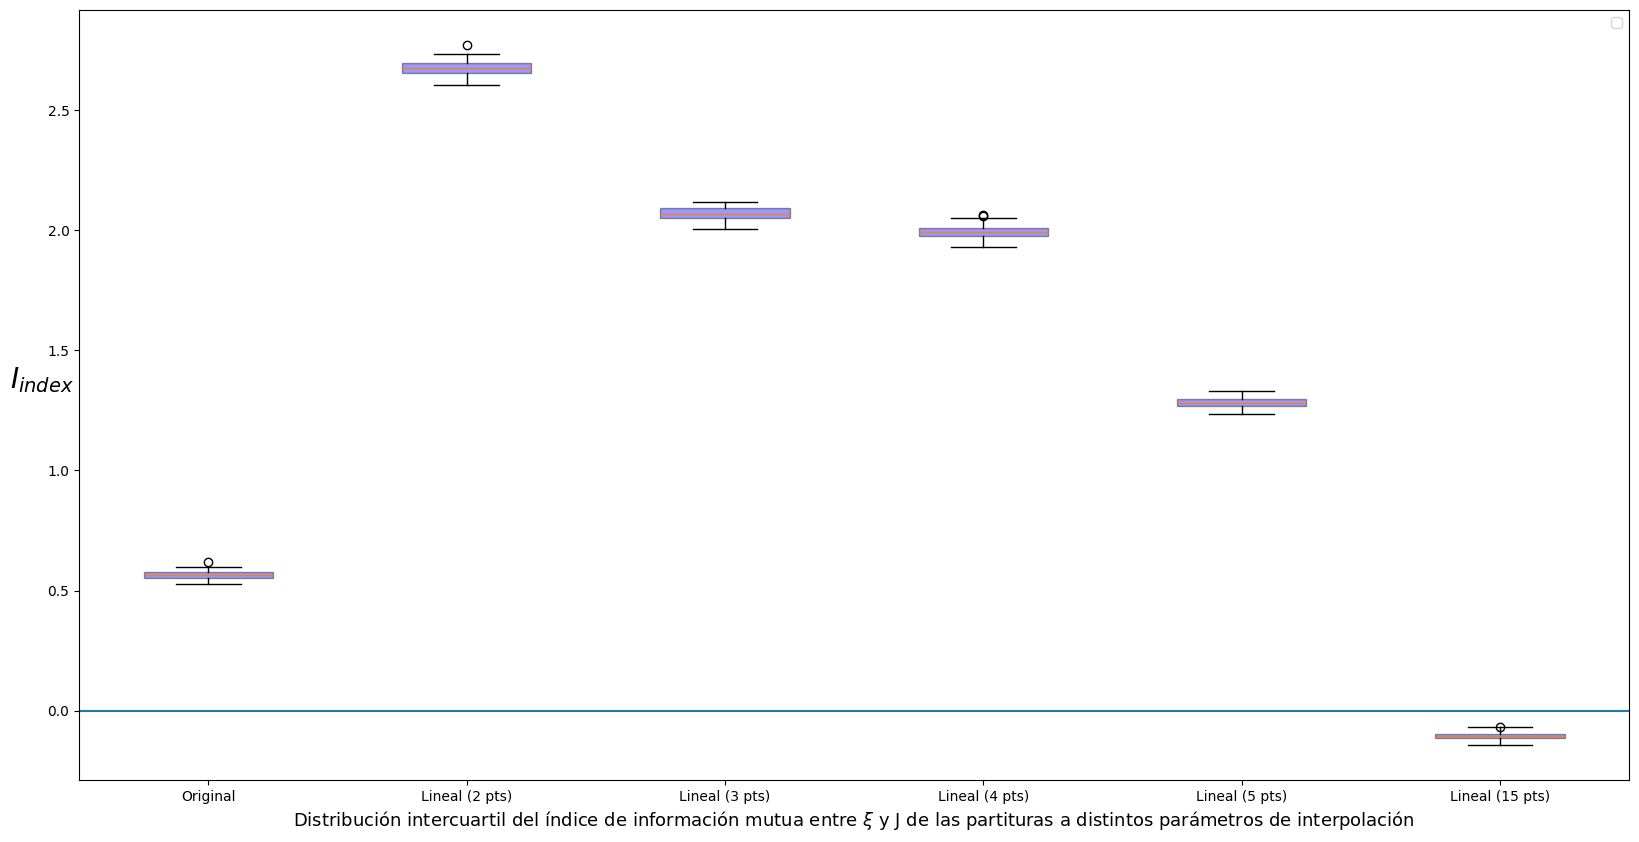

In [432]:
labels = ['Original', 'Lineal (2 pts)','Lineal (3 pts)','Lineal (4 pts)','Lineal (5 pts)',
 'Lineal (15 pts)']#,'Hermite (2 pts)','Hermite (5 pts)',
#  'Hermite (10 pts)','Hermite (15 pts)']
# labels= ['Lineal (5 pts)']#, 'Lineal (4pts)']
# labels = ['Random']

fig, ax = plt.subplots(figsize=(20, 10))
# box2 = ax.boxplot(J_OG, patch_artist=True)
box2 = ax.boxplot(data_bins[:6], patch_artist=True)

# Personalización de los boxplots
for patch in box2['boxes']:
    patch.set_facecolor('blue')
#     if patch == box2['boxes'][0]:
#         patch.set_label('Hermite')
    patch.set_alpha(0.4)
ax.axhline(y=0)
ax.set_xlabel(r'Distribución intercuartil del índice de información mutua entre $\xi$ y J de las partituras a distintos parámetros de interpolación', fontsize=13)
ax.set_ylabel(r'$I_{index}$',rotation=360, fontsize=20)
ax.set_xticks(np.arange(1, len(labels)+1))

# ax.scatter(np.arange(1, len(labels)), puntos1, color='red', s=50, zorder=3, marker = '*', label=r'$U\{\overline{N_J}\}$')
# ax.scatter(np.arange(1, len(labels)), puntos2, color='blue', s=25, zorder=3, marker = '*', label=r'$\overline{U\{ N_J \}}$')
# ax.plot(np.arange(1, len(labels)), puntos2, color='blue', linestyle='-', linewidth=0.8)

ax.set_xticklabels(labels, rotation=0)
ax.legend()

# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()
# ax.spines['top'].set_position(('axes', 1.0))
# ax.spines['bottom'].set_position(('axes', -0.1))

# plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

plt.show()

In [332]:
def mover_elemento(lista, indice_actual, nueva_posicion):
    elemento = lista.pop(indice_actual)  # Extrae el elemento de la posición actual
    lista.insert(nueva_posicion, elemento)  # Lo inserta en la nueva posición
    return lista

# Ejemplo de uso
lista = [10, 20, 30, 40, 50]
data = mover_elemento(data, 8, 9)  # Mueve el elemento en índice 1 (20) al índice 3
# print(nueva_lista)  # [10, 30, 40, 20, 50]
lista[-2:]


[40, 50]